In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv("all_stocks_5yr.csv", index_col="date", parse_dates=True)

In [37]:
data_pivot = data.pivot(values="close", columns="Name")

In [38]:
columns_notna = data_pivot.columns[data_pivot.isna().sum() == 0]

In [39]:
data_clean = data_pivot[columns_notna]

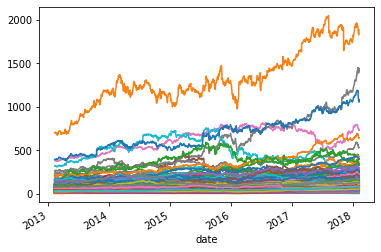

In [40]:
data_clean.plot(legend=False);

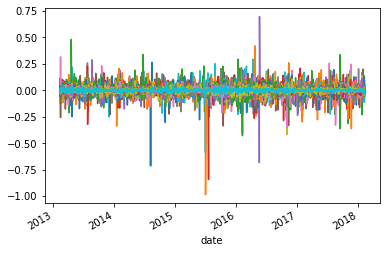

In [41]:
# tengo mis datos limpios

datax = np.log(data_clean)
datax = datax.diff()

datax = datax.drop(index=datax.index[0])

datax.plot(legend=False);

In [8]:
# Tiene el mercado componentes no lineales en su geometría?

In [42]:
datax.shape

(1258, 470)

In [43]:
datatest = datax[-200:]
datatrain = datax[:-200]

In [44]:
datatrain.shape

(1058, 470)

In [45]:
datax.shape

(1258, 470)

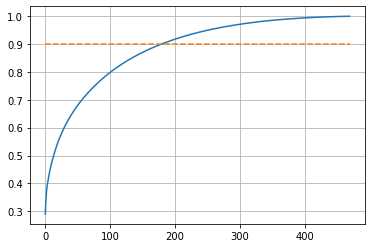

In [46]:
from sklearn.decomposition import PCA
pca = PCA()
components = pca.fit_transform(datatrain)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.plot(np.ones(470)*0.9, '--')
plt.grid()

In [90]:
z_dim = 5
pcafull = PCA(n_components=z_dim)
componentsfull = pcafull.fit_transform(datatrain)

In [91]:
from keras.losses import MSE

In [92]:
# error con pca
MSE(datatest.values.flatten(), pcafull.inverse_transform(pcafull.transform(datatest)).flatten())

<tf.Tensor: shape=(), dtype=float64, numpy=0.00017140589400806223>

In [93]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LeakyReLU

In [99]:
h_dim = 20
encoder = Sequential([
    Dense(h_dim, activation="relu", input_shape=(470,)),
    Dense(z_dim)
])

decoder = Sequential([
    Dense(h_dim, activation="relu", input_shape=(z_dim,)),
    Dense(470)
])

autoencoder = Sequential([encoder, decoder])

# h_dim = 70
# encoder = Sequential([
#     Dense(h_dim, input_shape=(470,)),
#     LeakyReLU(0.2),
#     Dense(h_dim),
#     LeakyReLU(0.2),
#     Dense(z_dim)
# ])

# decoder = Sequential([
#     Dense(h_dim, input_shape=(z_dim,)),
#     LeakyReLU(0.2),
#     Dense(h_dim),
#     LeakyReLU(0.2),
#     Dense(470)
# ])

# autoencoder = Sequential([encoder, decoder])

In [100]:
autoencoder.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 5)                 9525      
                                                                 
 sequential_28 (Sequential)  (None, 470)               9990      
                                                                 
Total params: 19,515
Trainable params: 19,515
Non-trainable params: 0
_________________________________________________________________


In [101]:
autoencoder.compile("adam", "mse")
history = autoencoder.fit(datatrain, datatrain, batch_size=128, shuffle=True, validation_data = (datatest, datatest), epochs=300)

Epoch 1/300
9/9 [==============================] - 1s 26ms/step - loss: 2.6836e-04 - val_loss: 2.3260e-04
Epoch 2/300
9/9 [==============================] - 0s 7ms/step - loss: 2.6589e-04 - val_loss: 2.3154e-04
Epoch 3/300
9/9 [==============================] - 0s 7ms/step - loss: 2.6414e-04 - val_loss: 2.3062e-04
Epoch 4/300
9/9 [==============================] - 0s 8ms/step - loss: 2.6176e-04 - val_loss: 2.2936e-04
Epoch 5/300
9/9 [==============================] - 0s 8ms/step - loss: 2.5769e-04 - val_loss: 2.2669e-04
Epoch 6/300
9/9 [==============================] - 0s 7ms/step - loss: 2.4994e-04 - val_loss: 2.2270e-04
Epoch 7/300
9/9 [==============================] - 0s 7ms/step - loss: 2.3899e-04 - val_loss: 2.1768e-04
Epoch 8/300
9/9 [==============================] - 0s 10ms/step - loss: 2.2589e-04 - val_loss: 2.1216e-04
Epoch 9/300
9/9 [==============================] - 0s 7ms/step - loss: 2.1309e-04 - val_loss: 2.0782e-04
Epoch 10/300
9/9 [==============================] - 0

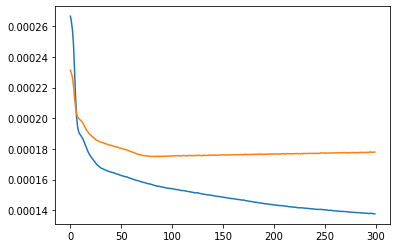

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [98]:
MSE(datatest.values.flatten(), autoencoder.predict(datatest).flatten())

<tf.Tensor: shape=(), dtype=float32, numpy=0.00017793008>